In [2]:
#!pip install -q transformers
!pip install easyocr

  Using cached easyocr-1.7.1-py3-none-any.whl (2.9 MB)
  Using cached python_bidi-0.4.2-py2.py3-none-any.whl (30 kB)


In [1]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [2]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

In [4]:
from google.colab import files

# Prompt the user to upload files
uploaded = files.upload()

# Print the uploaded file names
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')


Saving Adjusted-associations-between-health-insurance-benefit-design-comparing-having-both.png to Adjusted-associations-between-health-insurance-benefit-design-comparing-having-both.png
Uploaded file: Adjusted-associations-between-health-insurance-benefit-design-comparing-having-both.png


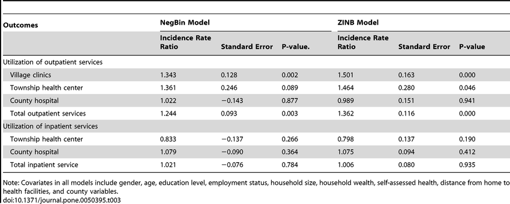

In [5]:
from PIL import Image

# Specify the file name of the uploaded image
file_name = "Adjusted-associations-between-health-insurance-benefit-design-comparing-having-both.png"

# Load the image using the file name
image = Image.open(file_name).convert("RGB")

# Display the image
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))


In [6]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 321, 800])


In [8]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [9]:

outputs.logits.shape

torch.Size([1, 15, 3])

In [10]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [11]:
objects = outputs_to_objects(outputs, image.size, id2label)


In [12]:
print(objects)

[{'label': 'table', 'score': 0.9999701976776123, 'bbox': [3.582599639892578, 30.97457504272461, 810.711181640625, 282.1034240722656]}]


In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

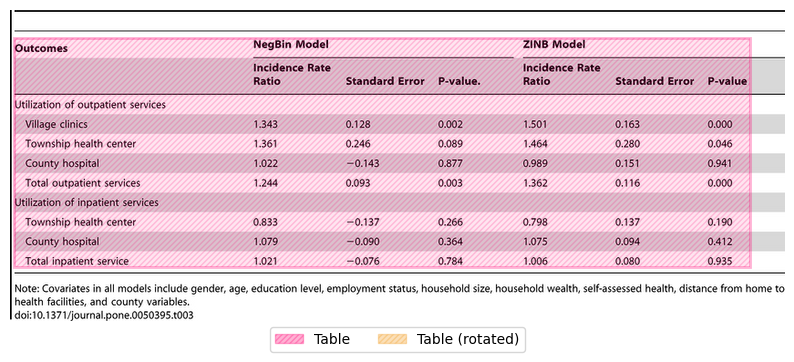

In [14]:
fig = visualize_detected_tables(image, objects)

In [15]:
visualized_image = fig2img(fig)

In [16]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [17]:
objects


[{'label': 'table',
  'score': 0.9999701976776123,
  'bbox': [3.582599639892578,
   30.97457504272461,
   810.711181640625,
   282.1034240722656]}]

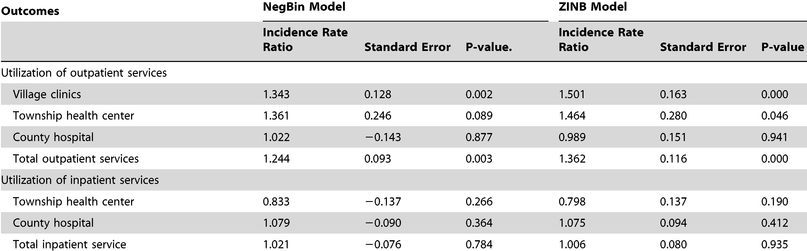

In [18]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [19]:
cropped_table.save("table.jpg")

In [20]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [21]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 311, 1000])


In [23]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [24]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9999703168869019, 'bbox': [212.82411193847656, 0.2595169246196747, 355.7209167480469, 249.24037170410156]}, {'label': 'table row', 'score': 0.9993853569030762, 'bbox': [0.07664886116981506, 82.4130630493164, 803.6622924804688, 103.86436462402344]}, {'label': 'table spanning cell', 'score': 0.9972750544548035, 'bbox': [-0.12145489454269409, 0.032434940338134766, 212.27340698242188, 58.8573112487793]}, {'label': 'table column', 'score': 0.9999814033508301, 'bbox': [651.6207275390625, 0.30006060004234314, 754.216064453125, 249.2836151123047]}, {'label': 'table column header', 'score': 0.9992051720619202, 'bbox': [0.03143396973609924, 0.10803543031215668, 803.703369140625, 59.10282897949219]}, {'label': 'table projected row header', 'score': 0.9977551102638245, 'bbox': [0.0030063092708587646, 168.23806762695312, 803.5767822265625, 189.5399169921875]}, {'label': 'table spanning cell', 'score': 0.9992789626121521, 'bbox': [213.08177185058594, 0.214578524

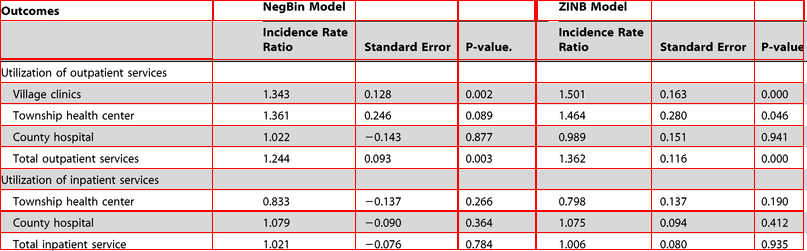

In [25]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [26]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

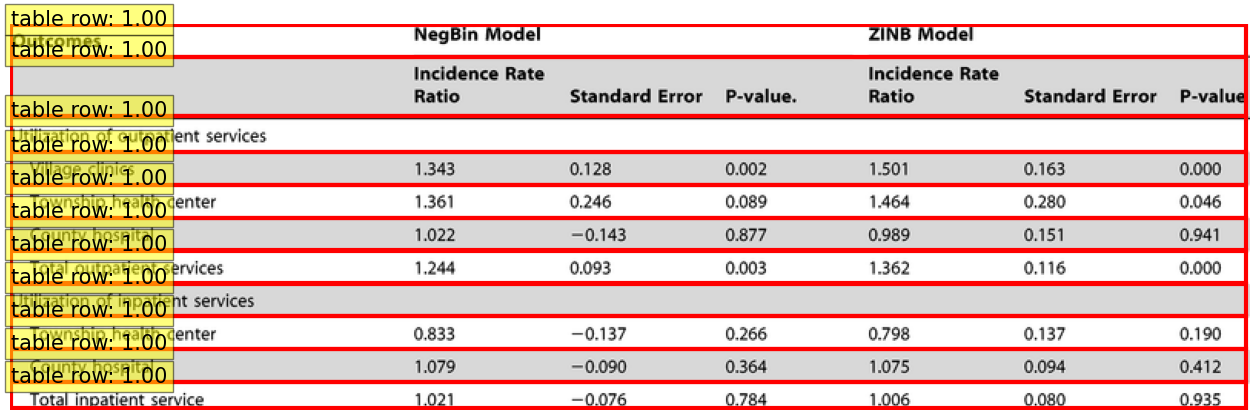

In [27]:
plot_results(cells, class_to_visualize="table row")

In [28]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [29]:
len(cell_coordinates)

11

In [30]:
len(cell_coordinates[0]["cells"])

7

In [31]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [-0.08077351748943329, 0.24356874823570251, 212.14418029785156, 249.30068969726562], 'cell': [-0.08077351748943329, 0.21456824243068695, 212.14418029785156, 20.970195770263672]}, {'column': [212.82411193847656, 0.2595169246196747, 355.7209167480469, 249.24037170410156], 'cell': [212.82411193847656, 0.21456824243068695, 355.7209167480469, 20.970195770263672]}, {'column': [355.5272521972656, 0.24099549651145935, 458.0482177734375, 249.20240783691406], 'cell': [355.5272521972656, 0.21456824243068695, 458.0482177734375, 20.970195770263672]}, {'column': [457.88018798828125, 0.2876282036304474, 535.4801025390625, 249.25550842285156], 'cell': [457.88018798828125, 0.21456824243068695, 535.4801025390625, 20.970195770263672]}, {'column': [536.2989501953125, 0.3093213140964508, 651.7678833007812, 249.29067993164062], 'cell': [536.2989501953125, 0.21456824243068695, 651.7678833007812, 20.970195770263672]}, {'column': [651.6207275390625, 0.30006060004234314, 754.216064453125, 249.283615

In [33]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.1 MB/s eta 0:00:00


In [34]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

  0%|          | 0/11 [00:00<?, ?it/s]

Max number of columns: 7
['Outcomes', 'NegBin Model', 'ZIMB Model', '', '', '', '']
['Incidence Rate Ratio', 'Standard Error', 'P-value_', 'Incidence Rate Ratio', 'Standard Error', 'P-value', '']
['Utilization of outpatient services', '', '', '', '', '', '']
['Village clinics', '1.3343', '0.128', '0.002', '1.501', '0.163', '0.000']
['Township health center', '1,361', '0.246', '0.089', '1.464', '0.280', '0.046']
['County hospital', '1.022', '0.143', '0.877', '0.989', '0.151', '0.941']
['Total outpatient services', '1,244', '0.093', '0.003', '1,362', '0.116', '0.000']
['Utilization of inpatient services', '', '', '', '', '', '']
['Township health center', '0.833', '0.137', '266', '0.798', '0.137', '0.190']
['County hospital', '1,079', '0.090', '0.364', '1.075', '0.094', '0412']
['Tona inparient senvic', '0.076', '0.784', '-006', '0.080', '0.935', '']


In [35]:
import csv

with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [36]:
import pandas as pd

df = pd.read_csv("output.csv")
df

,Outcomes,NegBin Model,ZIMB Model,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Incidence Rate Ratio,Standard Error,P-value_,Incidence Rate Ratio,Standard Error,P-value,NaN
1,Utilization of outpatient services,NaN,NaN,NaN,NaN,NaN,NaN
2,Village clinics,1.3343,0.128,0.002,1.501,0.163,0.000
3,Township health center,"1,361",0.246,0.089,1.464,0.280,0.046
4,County hospital,1.022,0.143,0.877,0.989,0.151,0.941
5,Total outpatient services,"1,244",0.093,0.003,"1,362",0.116,0.000
6,Utilization of inpatient services,NaN,NaN,NaN,NaN,NaN,NaN
7,Township health center,0.833,0.137,266,0.798,0.137,0.190
8,County hospital,"1,079",0.090,0.364,1.075,0.094,412.000
9,Tona inparient senvic,0.076,0.784,-006,0.080,0.935,NaN


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Unnamed: 6'].plot(kind='hist', bins=20, title='Unnamed: 6')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Outcomes').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Unnamed: 6', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Unnamed: 6']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Outcomes')):
  _plot_series(series, series_name, i)
  fig.legend(title='Outcomes', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Unnamed: 6')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Outcomes')):
  _plot_series(series, series_name, i)
  fig.legend(title='Outcomes', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Unnamed: 6'].plot(kind='line', figsize=(8, 4), title='Unnamed: 6')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Outcomes'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='Outcomes', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Outcomes'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Unnamed: 6', y='Outcomes', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)